# An Image is worth 16x16 words
# Transformers for image recognition at scale

https://arxiv.org/pdf/2010.11929.pdf

## Introduction

셀프어텐션 기반의 구조는 nlp에서 사용, 대부분 large text corpus 로 pre-train, smaller task-specific data로 fine-tune하는 방식, 트랜스포머 구조로 인해 아주 큰 모델도 학습이 가능  

비전에서는 여전히 cnn 구조가 지배적이였지만, NLP의 성공에 따라 cnn과 self-attention을 결합하거나 아예 전체를 replace해버리는 것을 시도. 이론적으로 효율적이나 특정한 어텐션 패턴의 사용으로서는 아직 적용x 이미지 인식에서는 여전히 resnet 구조가 sota  

기존의 트랜스포머를 이미지에 적용, 이미지를 패치로 나눠 시퀀스로서 트랜스포머의 입력으로 들어감. 이미지패치는 토큰으로서 이미지 분류로 학습됌.

이미지넷 같은 mid-sized datasets에 대해선 resnet 보다 낮은 정확도를 갖는다. 트랜스포머는 inductive biases 가 부족하나, 대용량 훈련이 강한 inductive biases를 가지게 하는 것을 알고 Vit가 높은 성능을 보임

## Related Works

트랜스포머를 활용한 다양한 nlp tasks, 주요 모델(BERT, GPT)  

기존의 나이브한 방법은 image에 self-attention을 그대로 적용시키는 것인데 이는 픽셀 갯수의 제곱만큼의 비용을 요구하여 real 이미지에는 적합 x.
따라서 local neighborhoods에 self-attention을 하거나 scalable approximation을 이용, 이러한 구조는 성능은 좋지만 복잡한 엔지니어링이 요구됐음  

가장 유사했던 연구는 2x2 패치를 이용했던 것, 저해상도의 이미지밖에 적용하지 못했음.
cnn에 self-attention을 결합한 여러 연구들도 많았음.
imageGPT 의 경우 해상도와 color space를 줄여 얻은 이미지 픽셀로 생성 모델을 학습

등등

## Method

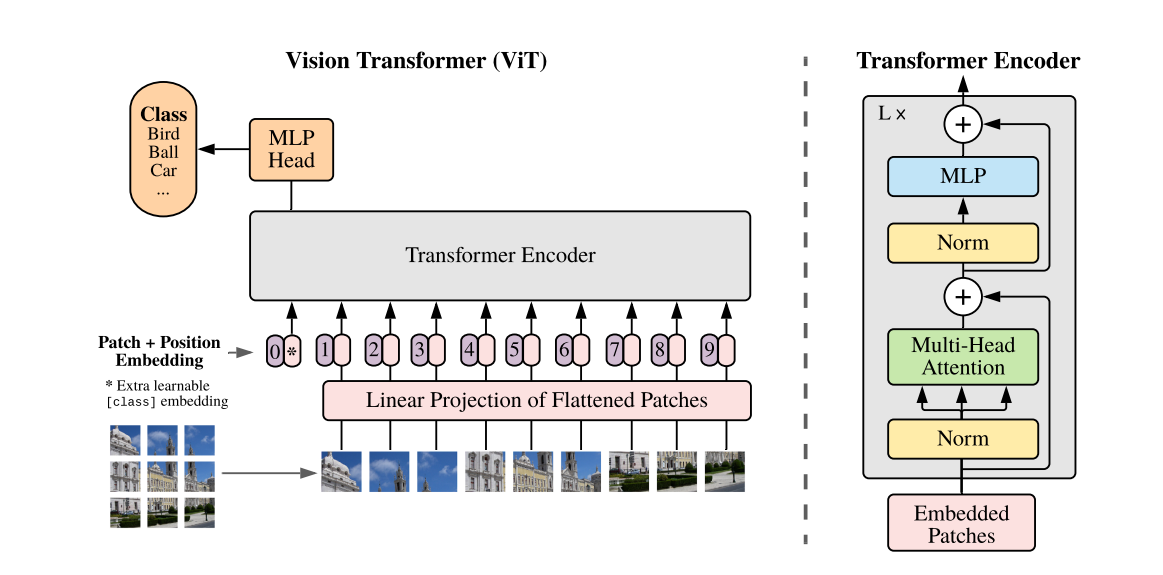

HxWxC 짜리의 이미지를 Nx(P^2*C)의 시퀀스로 변환  
position embedding, 이후는 기존 트랜스포머 구조와 매우 유사함  
ViT는 CNN보다 훨씬 적은 image-specific incductive bias를 가짐

Inductive bias, hybrid architecture, fine-tuning, high resolution에 관한 이야기

inductive bias란 학습데이터에서는 보지 못한 상황에서 정확한 예측을 하기 위한 추가적인 가정으로 cnn 같은 경우 지역적인 정보를, rnn 같은 경우 근접한 시퀀스의 정보를 활용하여 예측을 수행하는 것이 어떤 가정에서 부터 나온것, 트랜스포머는 positional embedding과 self-attention을 이용하여 모든정보를 활용하지만 inductive bias가 부족함 때문에 더 많은 데이터가 필요함.

## Experiment

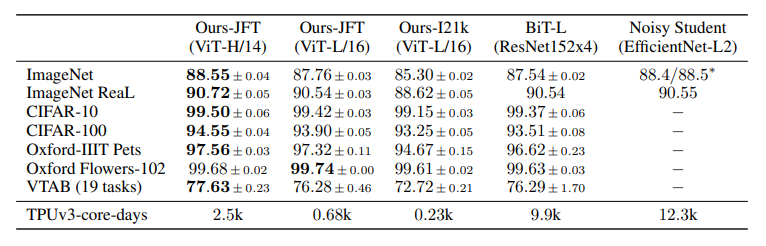

Table2

JFT-300M에서 pre-train 시킨 모델이 모든 데이터셋에서 ResNet보다 높은 성능을 보임

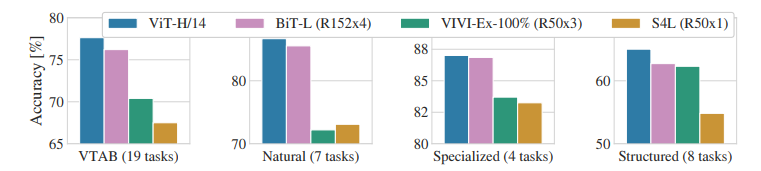

Figure2

VTAB tasks에서 이전의 sota 벤치마크와 비교했을때도 가장 우수한 성능

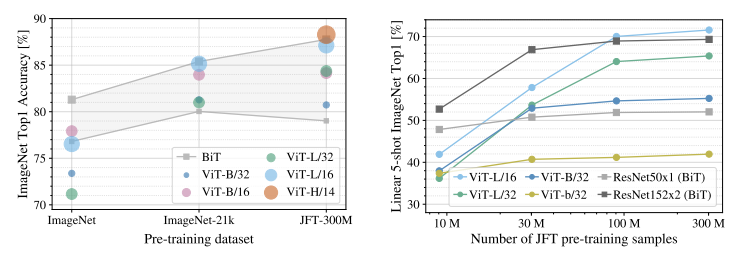

Figure3

small dataset으로 pre-train했을땐 성능이 좀 떨어짐.

Figure4

few-shot evaluation에 관한 결과 pre-train sample이 클수록 성능이 Resnet보다 나아짐

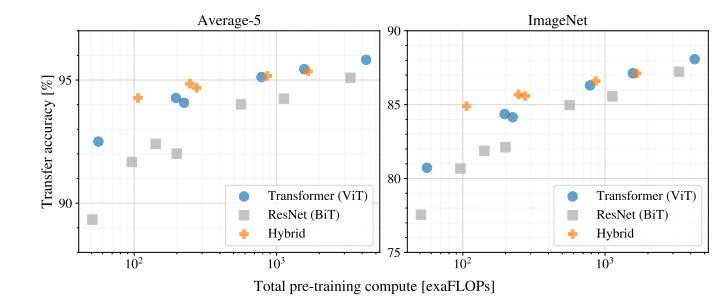

Figure5

동일한 계산량에서도 Vit가 높은 성능

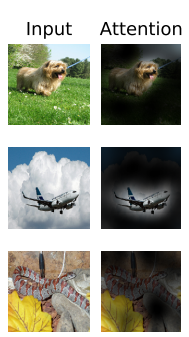

Figure6  
attention 시각화 모델이 class와 관련있는 부분에 집중하는 모습

# 코드 실습

In [ ]:
# 참고 : https://github.com/google-research/vision_transformer
# 참고 : https://github.com/FrancescoSaverioZuppichini/ViT

!pip install einops

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import OxfordIIITPet, MNIST
import torchvision.transforms as transforms
from torchsummary import summary

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchvision.datasets import ImageNet

In [ ]:
X_transforms = transforms.Compose([transforms.Resize((128,128)),
                                   transforms.ToTensor()])
data = ImageNet(root = './',split='train', download=True, transform=X_transforms)
#data = OxfordIIITPet('./data',download=True,transform = X_transforms)
#data = MNIST('./mnist', train=True, download=True, transform = X_transforms)
plt.imshow(data[0][0].numpy().transpose(1,2,0));

RuntimeError: ignored

In [ ]:
data[0][0].size()

torch.Size([1, 128, 128])

In [ ]:
# PARAMETER

NUM_CLASS = len(data.classes)
IN_CHANNEL = 1
IMAGE_SIZE = 128
PATCH_SIZE = 16
D_MODEL = 768
NUM_HEAD = 8
DROPOUT = 0.1
FFN_SIZE = 3072
NUM_LAYER = 12

In [ ]:
# patch embedding

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels = IN_CHANNEL, patch_size = PATCH_SIZE,
               emb_size = D_MODEL, img_size = IMAGE_SIZE):
    super().__init__()
    self.patch_size = patch_size
    self.projection = nn.Sequential(
        # patch embedding
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        # flatten
        Rearrange('b e (h) (w) -> b (h w) e'),
    )
    # learnable params for cls
    self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
    # learnable params for position
    self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

  def forward(self, x):
    b_size, _, _, _ = x.shape
    x = self.projection(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b_size)
    # concat cls, x
    x = torch.cat([cls_tokens, x], dim=1)
    # add position embedding
    x += self.positions
    return x

In [ ]:
X = data[0][0].unsqueeze(0)

X = PatchEmbedding()(X)
X.size()

torch.Size([1, 65, 768])

In [ ]:
# MHA

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size = D_MODEL, num_heads = NUM_HEAD, dropout = DROPOUT):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    # fuse the queries, keys and values in one matrix
    self.qkv = nn.Linear(emb_size, emb_size * 3)
    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x, mask=None):
    # split keys, queries, values
    qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
    Q, K, V = qkv[0], qkv[1], qkv[2]
    # sum up over the last axis > batch, num_heads, Q, K
    energy = torch.einsum('bhqd, bhkd -> bhqk', Q, K)
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min # 그냥 아주 작은수
      energy.mask_fill(~mask, fill_value) # masking

    scaling = (self.emb_size // self.num_heads)**0.5
    attention = F.softmax(energy, dim=-1) / scaling
    attention = self.att_drop(attention)
    # sum up over the third axis > batch, num_heads, attention, V
    out = torch.einsum('bhal, bhlv -> bhav ', attention, V)
    # concat
    out = rearrange(out, "b h n d -> b n (h d)")
    out = self.projection(out)
    return out

In [ ]:
X = MultiHeadAttention()(X)
X.size()

torch.Size([1, 65, 768])

In [ ]:
# Transformer Encoder

class Transformer_Encoder(nn.Module):
  def __init__(self, emb_size=D_MODEL, ffn_size = FFN_SIZE, dropout=DROPOUT):
    super(Transformer_Encoder, self).__init__()
    self.Layernorm1 = nn.LayerNorm(emb_size)
    self.MHAttention = MultiHeadAttention()
    self.Layernorm2 = nn.LayerNorm(emb_size)
    self.Linear1 = nn.Linear(emb_size, ffn_size)
    self.Linear2 = nn.Linear(ffn_size, emb_size)
    self.gelu = nn.GELU()
    self.dropout = dropout

  def forward(self, x):
    x_ = x
    x = self.Layernorm1(x)
    x = self.MHAttention(x)

    x_ = x_ + x
    x = nn.Dropout(self.dropout)(x)
    x = self.Layernorm2(x_)
    # ffn
    x = self.Linear1(x)
    x = self.gelu(x)
    x = nn.Dropout(self.dropout)(x)
    x = self.Linear2(x)

    x = x_ + x
    return x

In [ ]:
X = Transformer_Encoder()(X)
X.size()

torch.Size([1, 65, 768])

In [ ]:
# Vision Transformer

class Vision_Transformer(nn.Module):
  def __init__(self,num_layers = NUM_LAYER, emb_size=D_MODEL, num_classes=NUM_CLASS):
    super(Vision_Transformer, self).__init__()
    self.patch_embedding = PatchEmbedding()
    self.transformer_blocks = nn.ModuleList([Transformer_Encoder() for _ in range(num_layers)])
    self.linear_out = nn.Linear(emb_size, num_classes)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = self.patch_embedding(x)
    for block in self.transformer_blocks:
      x = block(x)
    #x = reduce(x, 'b n e -> b e', reduction='mean')
    x = x[:,0,:].view(-1,D_MODEL)
    x = self.linear_out(x)
    x = self.softmax(x)
    return x

In [ ]:
X = data[0][0].unsqueeze(0)
X = Vision_Transformer()(X)
X.size()

torch.Size([1, 10])

In [ ]:
summary(Vision_Transformer(), (1,128,128), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 8, 8]         197,376
         Rearrange-2              [-1, 64, 768]               0
    PatchEmbedding-3              [-1, 65, 768]               0
         LayerNorm-4              [-1, 65, 768]           1,536
            Linear-5             [-1, 65, 2304]       1,771,776
           Dropout-6            [-1, 8, 65, 65]               0
            Linear-7              [-1, 65, 768]         590,592
MultiHeadAttention-8              [-1, 65, 768]               0
         LayerNorm-9              [-1, 65, 768]           1,536
           Linear-10             [-1, 65, 3072]       2,362,368
             GELU-11             [-1, 65, 3072]               0
           Linear-12              [-1, 65, 768]       2,360,064
Transformer_Encoder-13              [-1, 65, 768]               0
        LayerNorm-14              [-1

In [ ]:
# train loader

train_dataset, test_dataset = torch.utils.data.random_split(data, [int(len(data)*0.7), int(len(data)*0.3)])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
# model & optimizer

n_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Vision_Transformer().to(device)
Loss = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999))
#sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.0001)

In [ ]:
pred = model(imgs)

In [ ]:
pred

tensor([[0.0370, 0.0538, 0.1499,  ..., 0.0786, 0.1119, 0.1471],
        [0.0277, 0.0768, 0.1498,  ..., 0.0728, 0.1303, 0.1699],
        [0.0253, 0.0680, 0.1438,  ..., 0.0691, 0.1286, 0.1784],
        ...,
        [0.0251, 0.0681, 0.1261,  ..., 0.0766, 0.1109, 0.1361],
        [0.0277, 0.0589, 0.1269,  ..., 0.0837, 0.1597, 0.1486],
        [0.0279, 0.0614, 0.1322,  ..., 0.0592, 0.1283, 0.1863]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
# training

L = []

for epoch in range(n_epochs):
  loss_sum = 0
  for i, (imgs,labels) in enumerate(train_loader):
    imgs = imgs.to(device)
    labels = F.one_hot(labels, num_classes=NUM_CLASS).type(torch.float).to(device)

    optimizer.zero_grad()
    preds = model(imgs).type(torch.float)
    loss = Loss(preds, labels)
    loss.backward()
    optimizer.step()

    loss_sum += loss.item()
  L.append(loss_sum)
  print('[%d/%d] [loss:%2.4f]' % (epoch+1, n_epochs,loss_sum/len(train_loader)))
  #sched.step()

[1/200] [loss:2.3620]
[2/200] [loss:2.3624]


KeyboardInterrupt: ignored

In [ ]:
plt.plot(L)
plt.show()

In [ ]:
# Test accuracy
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset))
with torch.no_grad():
  x,y = next(iter(test_loader))
  x = x.to(device)
  preds = model(x)
  preds = preds.argmax(dim=-1).detach().cpu()

print('accuracy :', sum(preds == y)/preds.size(0))